In [1]:

import os
import logging

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

# Log setting
logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

# Change display.max_rows to show all features.
pd.set_option("display.max_rows", 85)
     

In [4]:

file_name = os.path.join("dataset", "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")

In [5]:
# Read dataset
df = pd.read_csv(file_name, skipinitialspace=True, on_bad_lines="skip")

# Show number of NaN rows
print("Removing {} rows that contains only NaN values...".format(df[df.isna().all(axis=1)].shape[0]))

# Remove NaN rows
df = df[~ df.isna().all(axis=1)]

Removing 0 rows that contains only NaN values...


In [26]:
def _renaming_class_label(df: pd.DataFrame):
    labels = {"Web Attack Ã¯Â¿Â½ Brute Force": "Web Attack-Brute Force",
              "Web Attack Ã¯Â¿Â½ XSS": "Web Attack-XSS",
              "Web Attack Ã¯Â¿Â½ Sql Injection": "Web Attack-Sql Injection"}

    for old_label, new_label in labels.items():
        df.replace(old_label, new_label, inplace=True)

# Renaming labels
_renaming_class_label(df)

In [27]:
df['Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack-Brute Force', 'Web Attack-XSS',
       'Web Attack-Sql Injection', 'Infiltration', 'Bot', 'PortScan',
       'DDoS'], dtype=object)

In [28]:
df.to_csv(file_name, index=False)

In [29]:
DIR_PATH = "dataset"

FILE_NAMES = ["Monday-WorkingHours.pcap_ISCX.csv",
              "Tuesday-WorkingHours.pcap_ISCX.csv",
              "Wednesday-workingHours.pcap_ISCX.csv",
              "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
              "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
              "Friday-WorkingHours-Morning.pcap_ISCX.csv",
              "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
              "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"]

In [30]:
df = [pd.read_csv(os.path.join(DIR_PATH, f), skipinitialspace=True) for f in FILE_NAMES]
df = pd.concat(df, ignore_index=True)

In [31]:
df.Label.value_counts()

Label
BENIGN                      4378008
DoS Hulk                     462146
PortScan                     317860
DDoS                         256054
DoS GoldenEye                 20586
FTP-Patator                   15876
SSH-Patator                   11794
DoS slowloris                 11592
DoS Slowhttptest              10998
Bot                            3932
Web Attack-Brute Force         1507
Web Attack-XSS                  652
Infiltration                     72
Heartbleed                       22
Web Attack-Sql Injection         21
Name: count, dtype: int64

In [32]:
df.to_csv(os.path.join(DIR_PATH, "TrafficLabelling.csv"), index=False)

OSError: [Errno 28] No space left on device

In [12]:
df.shape

(2830743, 79)

In [15]:
DIR_PATH = "~/CICIDS_models/dataset/"
PROCESSED_DIR_PATH = "/Users/smalih/CICIDS_models/ProcessedDataset/"
FILE_PATH = os.path.join(DIR_PATH, "TrafficLabelling.csv")

In [19]:
def _label_encoding() -> LabelEncoder:
    # Create Label Encoder
    le = LabelEncoder()

    # Read Label column from all dataset files
    labels = pd.read_csv(FILE_PATH, usecols=['Label'], skipinitialspace=True)

    # Fit the labels data to Label Encoder
    le.fit(labels.Label)

    # Saving the label encoder
    print(PROCESSED_DIR_PATH)
    if not(os.path.exists(PROCESSED_DIR_PATH)):
        
    np.save(os.path.join(PROCESSED_DIR_PATH, 'label_encoder.npy'), le.classes_)

    # Log the result.
    logging.info("Total rows: {}".format(labels.shape))
    logging.info("Class distribution:\n{}\n".format(labels.Label.value_counts()))

    return le


def _process(df: pd.DataFrame, le: LabelEncoder) -> (np.ndarray, np.ndarray):
    # Label encoding
    df.Label = le.transform(df.Label)

    # Fill NaN with average value of each class in this dataset
    nan_rows = df[df.isna().any(axis=1)].shape[0]
    logging.info("Fill NaN in {} rows with average value of each class.".format(nan_rows))
    df.iloc[:, df.columns != "Label"] = df.groupby("Label").transform(lambda x: x.fillna(x.mean()))

    # Change inf value with maximum value of each class
    inf_rows = df[df.isin([np.inf]).any(axis=1)].shape[0]
    logging.info("Replace Inf in {} rows with maximum value of each class.".format(inf_rows))
    # Temporary replace inf with NaN
    df = df.replace([np.inf], np.nan)
    # Replace inf with maximum value of each class in this dataset
    df.iloc[:, df.columns != "Label"] = df.groupby("Label").transform(lambda x: x.fillna(x.max()))

    # Change negative value with minimum positive value of each class
    logging.info("Replace negative values with minimum value of each class.")
    # Temporary replace negative value with NaN
    df[df < 0] = np.nan
    # Replace negative value with minimum value of each class in this dataset
    df.iloc[:, df.columns != "Label"] = df.groupby("Label").transform(lambda x: x.fillna(x.min()))

    return df


def _split_train_test(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    # Sampling the dataset
    x = df.iloc[:, df.columns != 'Label']
    y = df[['Label']]

    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.20,
                                                        random_state=np.random.randint(10))

    del x, y

    train = pd.concat([x_train, y_train], axis=1, sort=False)
    test = pd.concat([x_test, y_test], axis=1, sort=False)

    return train, test


def _to_csv(df: pd.DataFrame, saving_path: str):
    # if file does not exist write header
    if not os.path.isfile(saving_path):
        df.to_csv(saving_path, index=False)
    # else it exists so append without writing the header
    else:
        df.to_csv(saving_path, index=False, mode='a', header=False)


def _preprocessing_all(le: LabelEncoder, chunksize=1000000):
    # Preprocess all file
    for chunk in pd.read_csv(FILE_PATH, skipinitialspace=True, chunksize=chunksize):
        train, test = _split_train_test(_process(chunk, le))
        _to_csv(train, os.path.join(PROCESSED_DIR_PATH, "train_MachineLearningCVE.csv"))
        _to_csv(test, os.path.join(PROCESSED_DIR_PATH, "test_MachineLearningCVE.csv"))
     

In [33]:

label_encoder = _label_encoding()
     

15:26:30 INFO Total rows: (3854342, 1)
15:26:30 INFO Class distribution:
Label
BENIGN                      3319096
DoS Hulk                     462146
DoS GoldenEye                 20586
FTP-Patator                   15876
SSH-Patator                   11794
DoS slowloris                 11592
DoS Slowhttptest              10998
Web Attack-Brute Force         1507
Web Attack-XSS                  652
Infiltration                     36
Heartbleed                       22
Web Attack-Sql Injection         21
Bot                              16
Name: count, dtype: int64



/Users/smalih/CICIDS_models/ProcessedDataset/


In [35]:
_preprocessing_all(label_encoder, 2500000)

15:34:28 INFO Fill NaN in 1464 rows with average value of each class.
15:34:37 INFO Replace Inf in 2625 rows with maximum value of each class.
15:34:47 INFO Replace negative values with minimum value of each class.
15:36:01 INFO Fill NaN in 1130 rows with average value of each class.
15:36:06 INFO Replace Inf in 1764 rows with maximum value of each class.
15:36:09 INFO Replace negative values with minimum value of each class.


In [16]:
def preprocessing(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    # Shuffle the dataset
    df = df.sample(frac=1)

    # Split features and labels
    x = df.iloc[:, df.columns != 'Label']
    y = df[['Label']].to_numpy()

    # Scale the features between 0 ~ 1
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    return x, y


def reshape_dataset_cnn(x: np.ndarray) -> np.ndarray:
    # Add padding columns
    result = np.zeros((x.shape[0], 81))
    result[:, :-3] = x

    # Reshaping dataset
    result = np.reshape(result, (result.shape[0], 9, 9))
    result = result[..., tf.newaxis]
    return result


def plot_history(history: tf.keras.callbacks.History):
    # summarize history for accuracy
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model2 accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model2 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def evaluation(model: keras.Model, x_test: np.ndarray, y_test: np.ndarray):
    score = model.evaluate(x_test, y_test, verbose=False)
    logging.info('Evaluation:\nLoss: {}\nAccuracy : {}\n'.format(score[0], score[1]))

    # F1 score
    y_pred = model.predict(x_test, batch_size=1024, verbose=False)
    y_pred = np.argmax(y_pred, axis=1)

    logging.info("\n{}".format(classification_report(y_test, y_pred)))


In [17]:

def create_cnn_model() -> keras.Model:
    # Creating layers
    inputs = keras.layers.Input(shape=(9, 9, 1))
    x = keras.layers.Conv2D(120, 2, activation='relu', padding="same")(inputs)
    x = keras.layers.Conv2D(60, 3, activation='relu', padding="same")(x)
    x = keras.layers.Conv2D(30, 4, activation='relu', padding="same")(x)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(15, activation='softmax')(x)
    cnn_model = keras.Model(inputs=inputs, outputs=outputs, name='cnn')

    # Compile layers
    cnn_model.compile(loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'],
                      optimizer='adam')

    return cnn_model

In [40]:

# Create model
model = create_cnn_model()
logging.info(model.summary())

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9, 9, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 9, 9, 120)      │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 9, 60)       │        64,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 30)       │        28,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2430)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        36,465 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,755 (510.76 KB)

 Trainable params: 130,755 (510.76 KB)

 Non-trainable params: 0 (0.00 B)

15:41:14 INFO None


In [43]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [18]:
MODEL_DIR_PATH = "/Users/smalih/CICIDS_models/Model"

In [56]:
cp_path = os.path.join(MODEL_DIR_PATH, "5_2_cnn_weights-improvement-{epoch:02d}-{val_sparse_categorical_accuracy:.2f}.weight.h5")
checkpoint = ModelCheckpoint(cp_path, monitor='val_sparse_categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Training
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'train_MachineLearningCVE.csv'), skipinitialspace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

16:16:17 INFO Class distribution
Label
0     2668943
3      371178
2       16531
6       12794
9        9487
5        9310
4        8828
10       1205
12        522
8          29
7          19
11         17
1          13
Name: count, dtype: int64


In [49]:
X, Y = preprocessing(df)
del df
X = reshape_dataset_cnn(X)

In [50]:

# Training
logging.info("*** TRAINING START ***")
history = model.fit(X, Y, validation_split=0.1, epochs=125, batch_size=1024, verbose=True)

15:49:50 INFO *** TRAINING START ***


Epoch 1/125
2724/2724 ━━━━━━━━━━━━━━━━━━━━ 527s 193ms/step - loss: 0.1493 - sparse_categorical_accuracy: 0.9640 - val_loss: 0.0121 - val_sparse_categorical_accuracy: 0.9967
Epoch 2/125
2724/2724 ━━━━━━━━━━━━━━━━━━━━ 502s 184ms/step - loss: 0.0091 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0058 - val_sparse_categorical_accuracy: 0.9983
Epoch 3/125
2724/2724 ━━━━━━━━━━━━━━━━━━━━ 488s 179ms/step - loss: 0.0054 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.0048 - val_sparse_categorical_accuracy: 0.9989
Epoch 4/125
2724/2724 ━━━━━━━━━━━━━━━━━━━━ 486s 179ms/step - loss: 0.0041 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.0031 - val_sparse_categorical_accuracy: 0.9991
Epoch 5/125
2724/2724 ━━━━━━━━━━━━━━━━━━━━ 483s 177ms/step - loss: 0.0034 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.0028 - val_sparse_categorical_accuracy: 0.9991
Epoch 6/125
2724/2724 ━━━━━━━━━━━━━━━━━━━━ 484s 177ms/step - loss: 0.0028 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0035 - va

In [51]:
logging.info("*** TRAINING FINISH ***")
del X, Y

08:45:43 INFO *** TRAINING FINISH ***


08:45:46 WARNING You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


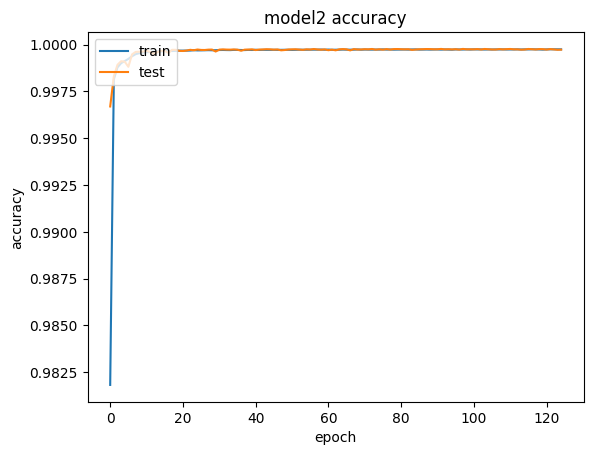

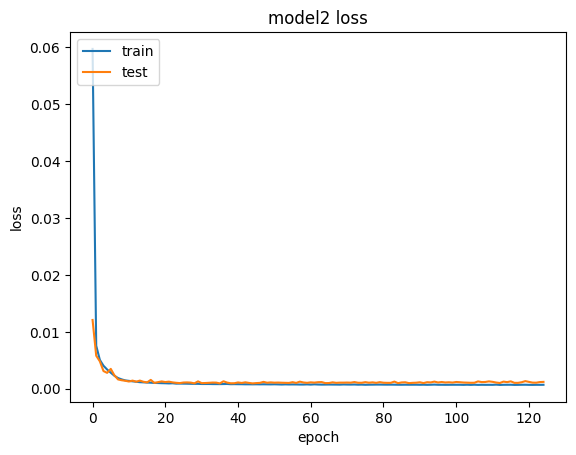

In [52]:
# Save the model
model.save(os.path.join(MODEL_DIR_PATH, "06_cnn.h5"))

plot_history(history)

In [53]:
# Evaluation
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'test_MachineLearningCVE.csv'), skipinitialspace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

10:52:09 INFO Class distribution
Label
0     663820
3      92430
2       4118
6       3175
9       2358
5       2318
4       2200
10       302
12       130
8          7
7          4
11         4
1          3
Name: count, dtype: int64


In [54]:
X, Y = preprocessing(df)
del df
X = reshape_dataset_cnn(X)

In [55]:
evaluation(model, X, Y)
del X, Y
     

10:54:08 INFO Evaluation:
Loss: 0.02192193642258644
Accuracy : 0.9981566071510315

10:54:44 INFO 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    663820
           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00      4118
           3       1.00      1.00      1.00     92430
           4       0.99      0.98      0.98      2200
           5       0.98      1.00      0.99      2318
           6       1.00      1.00      1.00      3175
           7       1.00      1.00      1.00         4
           8       1.00      0.71      0.83         7
           9       1.00      0.50      0.67      2358
          10       0.70      0.95      0.81       302
          11       1.00      0.25      0.40         4
          12       1.00      0.05      0.09       130

    accuracy                           1.00    770869
   macro avg       0.97      0.78      0.81    770869
weighted avg       1.00      1.00   

In [57]:
X, Y = preprocessing(df)

In [59]:
X = reshape_dataset_cnn(X)
untrained_model = create_cnn_model()
loss, acc = untrained_model.evaluate(X, Y, verbose=2)

96840/96840 - 356s - 4ms/step - loss: 2.7061 - sparse_categorical_accuracy: 0.0152


In [60]:
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

Untrained model, accuracy:  1.52%


In [62]:
new_model = tf.keras.models.load_model('Model/06_cnn.h5')
loss, acc = new_model.evaluate(X, Y, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

12:51:57 WARNING Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


96840/96840 - 352s - 4ms/step - loss: 7.4587e-04 - sparse_categorical_accuracy: 0.9997
Restored model, accuracy: 99.97%


In [7]:
python_df = pd.read_csv('example.csv')
python_df = pd.read_csv('rbp.csv')
py_cols = list(python_df.columns)

DATA_PATH = "~/CICIDS_models/dataset/TrafficLabelling.csv"
dataset = pd.read_csv(DATA_PATH)
dataset_cols = list(pd.read_csv('dataset_columns.csv').columns)
# dataset_cols = ["","",""] + dataset_cols

# ", ".join(py_cols)

# scaler = MinMaxScaler()
# X = scaler.fit_transform(example_df)
# # X = reshape_dataset_cnn(example_df)
# # print(X)
print(len(dataset_cols))
print(len(py_cols))

print(dataset['Fwd Header Length.1'] == dataset['Fwd Header Length'])


# with open('columns_compare.csv', 'w') as cols_compare:
#     pairs = list(zip(dataset_cols, py_cols))
#     for i in range(len(pairs)):
#         pair = pairs[i]
#         cols_compare.write(f"{i} {pair[0]}\t{pair[1]}\n")
#     # for i in range(-2,0):
#     #     cols_compare.write(f"\"\"\t{py_cols[i]}\n")

# for i in range((max(len(dataset_cols), len(py_cols)))):
#     print(dataset_cols[min(i, len(dataset_cols)-1)], py_cols[min(i, len(py_cols)-1)])


79
77
0          True
1          True
2          True
3          True
4          True
           ... 
3854337    True
3854338    True
3854339    True
3854340    True
3854341    True
Length: 3854342, dtype: bool


In [24]:
print((dataset['Fwd IAT Total'] == dataset['Fwd Header Length']).all())


False


In [13]:
print(df.shape)

(2830743, 79)


In [25]:
corr = dataset.corr(numeric_only=True).round(2)

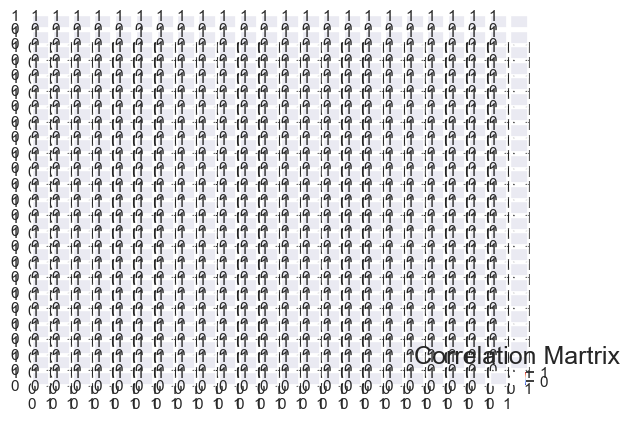

In [28]:
import seaborn as sns
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(24, 24)
sns.heatmap(corr, cmap='coolwarm', annot=False, linewidth=0.5)
plt.title('Correlation Martrix', fontsize=18)
plt.show()

In [34]:
# print(corr)
correlated_features = np.where(np.abs(corr) > 0.95) # select ones above the abs 0.95
correlated_features = [(corr.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value

if s_corr_list == []:
    print("There are no highly correlated features with correlation above", 0.95)
else:
    for v, i, j in s_corr_list:
        cols = dataset.columns
        print ("%s and %s = %.3f" % (corr.index[i], corr.columns[j], v))

Flow Duration and Fwd IAT Total = 1.000
Total Fwd Packets and Total Backward Packets = 1.000
Total Fwd Packets and Total Length of Bwd Packets = 1.000
Total Fwd Packets and Subflow Fwd Packets = 1.000
Total Fwd Packets and Subflow Bwd Packets = 1.000
Total Fwd Packets and Subflow Bwd Bytes = 1.000
Total Backward Packets and Subflow Fwd Packets = 1.000
Total Backward Packets and Subflow Bwd Packets = 1.000
Total Length of Fwd Packets and Subflow Fwd Bytes = 1.000
Total Length of Bwd Packets and Subflow Fwd Packets = 1.000
Total Length of Bwd Packets and Subflow Bwd Bytes = 1.000
Fwd Packet Length Mean and Avg Fwd Segment Size = 1.000
Bwd Packet Length Mean and Avg Bwd Segment Size = 1.000
Flow IAT Max and Fwd IAT Max = 1.000
Fwd PSH Flags and SYN Flag Count = 1.000
Fwd URG Flags and CWE Flag Count = 1.000
Fwd Header Length and Fwd Header Length.1 = 1.000
Packet Length Mean and Average Packet Size = 1.000
RST Flag Count and ECE Flag Count = 1.000
Subflow Fwd Packets and Subflow Bwd Packe

In [42]:
# get upper triangle of correlation matrix

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
print(upper)
# find features with correlation greater than 0.95

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# drop highly correlated features

new_df = df.drop(to_drop, axis=1, inplace=False)

                             Destination Port  Flow Duration  \
Destination Port                          NaN          -0.19   
Flow Duration                             NaN            NaN   
Total Fwd Packets                         NaN            NaN   
Total Backward Packets                    NaN            NaN   
Total Length of Fwd Packets               NaN            NaN   
Total Length of Bwd Packets               NaN            NaN   
Fwd Packet Length Max                     NaN            NaN   
Fwd Packet Length Min                     NaN            NaN   
Fwd Packet Length Mean                    NaN            NaN   
Fwd Packet Length Std                     NaN            NaN   
Bwd Packet Length Max                     NaN            NaN   
Bwd Packet Length Min                     NaN            NaN   
Bwd Packet Length Mean                    NaN            NaN   
Bwd Packet Length Std                     NaN            NaN   
Flow Bytes/s                            

In [39]:
new_df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Length of Fwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Total',
       'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
       'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Bwd Packets/s',
       'Min Packet Length', 'Packet Length Mean', 'Packet Length Variance',
       'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag Count', 'Down/Up Ratio', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Ra

In [2]:


def remove_strongly_correlated(df, threshold, print_columns=False):
    corr = df.corr(numeric_only=True)
    correlated_features = np.where(np.abs(corr) > threshold) # select ones above the abs threshold
    correlated_features = [(corr.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value
    to_drop = []
    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        for v, i, j in s_corr_list:
            to_drop.append(corr.index[i])
            if print_columns:
                print ("%s and %s = %.3f" % (corr.index[i], corr.columns[j], v))

    # drop strongly correlated features
    return df.drop(to_drop, axis=1, inplace=False)

In [35]:
std = dataset.std(numeric_only=True)
zero_std_cols = std[std == 0].index.tolist()
zero_std_cols

/Users/smalih/CICIDS_models/venv/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


['Bwd PSH Flags',
 'Bwd URG Flags',
 'Fwd Avg Bytes/Bulk',
 'Fwd Avg Packets/Bulk',
 'Fwd Avg Bulk Rate',
 'Bwd Avg Bytes/Bulk',
 'Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate']

In [50]:
print(temp_df.shape)


(2830743, 57)


In [52]:
corr = temp_df.corr(numeric_only=True).round(2)
correlated_features = np.where(np.abs(corr) > 0.9) # select ones above the abs 0.95
correlated_features = [(corr.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value

if s_corr_list == []:
    print("There are no highly correlated features with correlation above", 0.95)
else:
    for v, i, j in s_corr_list:
        cols = dataset.columns
        print ("%s and %s = %.3f" % (corr.index[i], corr.columns[j], v))

Bwd Packet Length Std and Packet Length Std = 0.940
Bwd Packet Length Std and Avg Bwd Segment Size = 0.940
Packet Length Std and Average Packet Size = 0.940
Bwd IAT Mean and Bwd IAT Min = 0.930
Packet Length Std and Packet Length Variance = 0.920
Packet Length Std and Avg Bwd Segment Size = 0.920
Average Packet Size and Avg Bwd Segment Size = 0.920
Flow IAT Std and Idle Min = 0.910
Active Mean and Active Min = 0.910


In [56]:
dataset = remove_strongly_correlated(dataset, 0.95, True)

Total Fwd Packets and Subflow Fwd Packets = 0.910
Total Backward Packets and Subflow Bwd Packets = 0.910
Fwd Packet Length Mean and Avg Fwd Segment Size = 0.910
Fwd PSH Flags and SYN Flag Count = 0.910
Fwd URG Flags and CWE Flag Count = 0.910
Fwd Header Length and Fwd Header Length.1 = 0.910
Bwd Packet Length Mean and Avg Bwd Segment Size = 0.910
Total Length of Bwd Packets and Subflow Bwd Bytes = 0.910
Total Length of Fwd Packets and Subflow Fwd Bytes = 0.910
Total Fwd Packets and Total Backward Packets = 0.910
Total Fwd Packets and Subflow Bwd Packets = 0.910
Subflow Fwd Packets and Subflow Bwd Packets = 0.910
Total Backward Packets and Subflow Fwd Packets = 0.910
Flow Duration and Fwd IAT Total = 0.910
Flow IAT Max and Fwd IAT Max = 0.910
Packet Length Mean and Average Packet Size = 0.910
Total Fwd Packets and Total Length of Bwd Packets = 0.910
Total Length of Bwd Packets and Subflow Fwd Packets = 0.910
Total Fwd Packets and Subflow Bwd Bytes = 0.910
Subflow Fwd Packets and Subflow

,Destination Port,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Std,Bwd Packet Length Min,Flow Bytes/s,Flow IAT Mean,Flow IAT Std,Flow IAT Min,Fwd IAT Total,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Std,Idle Min,Label
0,49188,6,6,0.0,0,3.000000e+06,4.000000,0.000000,4,4,...,-1,1,20,0.0,0.0,0,0,0.0,0,BENIGN
1,49188,6,6,0.0,0,1.200000e+07,1.000000,0.000000,1,1,...,-1,1,20,0.0,0.0,0,0,0.0,0,BENIGN
2,49188,6,6,0.0,0,1.200000e+07,1.000000,0.000000,1,1,...,-1,1,20,0.0,0.0,0,0,0.0,0,BENIGN
3,49188,6,6,0.0,0,1.200000e+07,1.000000,0.000000,1,1,...,-1,1,20,0.0,0.0,0,0,0.0,0,BENIGN
4,49486,6,6,0.0,0,4.000000e+06,3.000000,0.000000,3,3,...,-1,1,20,0.0,0.0,0,0,0.0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3854337,53,30,30,0.0,308,2.223684e+06,101.333333,169.453042,3,3,...,-1,1,32,0.0,0.0,0,0,0.0,0,BENIGN
3854338,51741,6,6,0.0,0,3.000000e+06,4.000000,0.000000,4,4,...,-1,1,20,0.0,0.0,0,0,0.0,0,BENIGN
3854339,51070,6,6,0.0,0,3.000000e+06,4.000000,0.000000,4,4,...,-1,1,20,0.0,0.0,0,0,0.0,0,BENIGN
3854340,51003,6,6,0.0,0,3.000000e+06,4.000000,0.000000,4,4,...,-1,1,20,0.0,0.0,0,0,0.0,0,BENIGN


In [3]:
def remove_zero_std_features(df, print_columns=True):
    std_devs = df.std(numeric_only=True)
    zero_std_dev_cols = std_devs[std_devs == 0].index.tolist()
    if print_columns:
        zero_std_dev_cols

    # drop zero std deviation features
    return df.drop(zero_std_dev_cols, axis=1, inplace=False)    

In [39]:
def handle_inf_values(df):
    return df.replace([np.inf, -np.inf], np.nan, inplace=False)

In [60]:
def handle_missing_values(df):
    missing = df.isna().sum()

    med_flow_bytes = df['Flow Bytes/s'].median()
    new_df = df
    new_df['Flow Bytes/s'].fillna(med_flow_bytes, inplace=True)
    return new_df

In [5]:


def pre_process(df, threshold, print_columns=False):
    new_df = remove_strongly_correlated(df, threshold, print_columns)
    new_df = remove_zero_std_features(new_df, print_columns)
    return new_df 

In [8]:
# print(dataset)
processed_dataset = pre_process(dataset, 0.95, print_columns=True)
print(processed_dataset)

Total Fwd Packets and Subflow Fwd Packets = 1.000
Total Backward Packets and Subflow Bwd Packets = 1.000
Fwd Packet Length Mean and Avg Fwd Segment Size = 1.000
Fwd PSH Flags and SYN Flag Count = 1.000
Fwd URG Flags and CWE Flag Count = 1.000
Fwd Header Length and Fwd Header Length.1 = 1.000
Bwd Packet Length Mean and Avg Bwd Segment Size = 1.000
Total Length of Bwd Packets and Subflow Bwd Bytes = 1.000
Total Length of Fwd Packets and Subflow Fwd Bytes = 1.000
Total Fwd Packets and Total Backward Packets = 0.999
Total Fwd Packets and Subflow Bwd Packets = 0.999
Subflow Fwd Packets and Subflow Bwd Packets = 0.999
Total Backward Packets and Subflow Fwd Packets = 0.999
Flow Duration and Fwd IAT Total = 0.999
Flow IAT Max and Fwd IAT Max = 0.999
Packet Length Mean and Average Packet Size = 0.997
Total Fwd Packets and Total Length of Bwd Packets = 0.997
Total Length of Bwd Packets and Subflow Fwd Packets = 0.997
Total Fwd Packets and Subflow Bwd Bytes = 0.997
Subflow Fwd Packets and Subflow

/Users/smalih/CICIDS_models/venv/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


         Destination Port  Fwd Packet Length Max  Fwd Packet Length Min  \
0                   49188                      6                      6   
1                   49188                      6                      6   
2                   49188                      6                      6   
3                   49188                      6                      6   
4                   49486                      6                      6   
...                   ...                    ...                    ...   
3854337                53                     30                     30   
3854338             51741                      6                      6   
3854339             51070                      6                      6   
3854340             51003                      6                      6   
3854341             51058                      6                      6   

         Fwd Packet Length Std  Bwd Packet Length Min  Flow Bytes/s  \
0                          0

In [61]:
df = handle_inf_values(processed_dataset)
# print(df)
df = handle_missing_values(df)

print(df)



/var/folders/tc/tc6_p9n93wj6kgbznk8tlf780000gn/T/ipykernel_77202/3989393193.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_df['Flow Bytes/s'].fillna(med_flow_bytes, inplace=True)


         Destination Port  Fwd Packet Length Max  Fwd Packet Length Min  \
0                   49188                      6                      6   
1                   49188                      6                      6   
2                   49188                      6                      6   
3                   49188                      6                      6   
4                   49486                      6                      6   
...                   ...                    ...                    ...   
3854337                53                     30                     30   
3854338             51741                      6                      6   
3854339             51070                      6                      6   
3854340             51003                      6                      6   
3854341             51058                      6                      6   

         Fwd Packet Length Std  Bwd Packet Length Min  Flow Bytes/s  \
0                          0

In [65]:

# Standardizing the dataset
from sklearn.preprocessing import StandardScaler

features = df.drop('Label', axis=1)
attacks = df['Label']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
# # df[df[:, :-3] < 0]

In [97]:

from sklearn.decomposition import PCA
X = df.iloc[:,:-1]

pca = PCA(20)
pca.fit(X)

PCA(n_components=20)

In [98]:
print(f'information retained: {sum(pca.explained_variance_ratio_)}')


information retained: 0.9999634040385184


In [100]:
transformed_features = pca.transform(features)

new_data = pd.DataFrame(transformed_features, columns =[f'PC{i+1}' for i in range(20)])
new_data['Label'] = attacks.values

In [102]:
new_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,Label
0,-2.388578e+07,9.733464e+05,41261.309870,714143.954421,1.423244e+06,894114.303436,-218740.871127,-184353.965768,-52067.609316,-6392.518950,...,3142.704741,19081.511174,73091.586176,-62125.646883,-91937.235476,-96454.165511,1189.501152,-27482.679590,8437.013722,BENIGN
1,-2.405355e+07,9.974623e+06,33622.488639,657949.365530,1.367416e+06,869609.045137,-214685.605807,-181302.009410,-51787.722767,-7287.941058,...,3186.916500,19106.551675,75057.655407,-65949.980310,-103788.233004,-121261.686342,1427.650615,-38505.183282,14548.092276,BENIGN
2,-2.405355e+07,9.974623e+06,33622.488639,657949.365530,1.367416e+06,869609.045137,-214685.605807,-181302.009410,-51787.722767,-7287.941058,...,3186.916500,19106.551675,75057.655407,-65949.980310,-103788.233004,-121261.686342,1427.650615,-38505.183282,14548.092276,BENIGN
3,-2.405355e+07,9.974623e+06,33622.488639,657949.365530,1.367416e+06,869609.045137,-214685.605807,-181302.009410,-51787.722767,-7287.941058,...,3186.916500,19106.551675,75057.655407,-65949.980310,-103788.233004,-121261.686342,1427.650615,-38505.183282,14548.092276,BENIGN
4,-2.390442e+07,1.973488e+06,40412.552202,707900.268801,1.417041e+06,891392.357854,-218291.339455,-184014.799304,-52036.473553,-6492.006008,...,3147.618717,19084.332029,73310.218885,-62550.720179,-93254.359802,-99211.010025,1215.966049,-28707.736486,9116.142693,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3854337,-2.387079e+07,1.961492e+05,41944.744594,718402.574308,1.427735e+06,896462.385134,-218881.756231,-184239.083284,-51378.216105,-5509.601581,...,3184.912018,19695.088664,71846.351140,-60569.252626,-87044.111947,-66892.269491,1035.562938,-20252.532543,4612.057343,BENIGN
3854338,-2.388578e+07,9.733465e+05,41261.310713,714143.959119,1.423244e+06,894114.473492,-218740.979304,-184354.106191,-52067.730546,-6392.534491,...,3142.721650,19081.479506,73092.456282,-62126.851831,-91939.271246,-96456.828454,1189.536584,-27484.709305,8438.147141,BENIGN
3854339,-2.388578e+07,9.733465e+05,41261.310472,714143.951265,1.423244e+06,894114.432824,-218740.960468,-184354.067839,-52067.690157,-6392.528444,...,3142.716580,19081.511948,73092.240060,-62126.559472,-91938.824128,-96456.248370,1189.527060,-27484.269733,8437.846809,BENIGN
3854340,-2.388578e+07,9.733465e+05,41261.310591,714143.999505,1.423244e+06,894114.398936,-218740.887515,-184354.074714,-52067.749277,-6392.542373,...,3142.720709,19081.336554,73092.126141,-62126.350045,-91938.128173,-96455.303076,1189.527675,-27483.530428,8437.834878,BENIGN
